# **Classification of Anomalies in the Gastrointestinal Tract using Deep Learning**
## Using **KVASIR** dataset

In [1]:
# Necessary imports

import cv2
import glob
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


## Loading the dataset

#### Download the dataset and extract the class folders

In [4]:
!wget https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip

--2021-03-16 15:49:01--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  70.7MB/s    in 31s     

2021-03-16 15:49:32 (75.7 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



In [5]:
!unzip "/content/kvasir-dataset-v2.zip"

Streaming output truncated to the last 5000 lines.
  inflating: kvasir-dataset-v2/normal-pylorus/79b990c2-870b-4cdd-8d8d-ad7ea33e0258.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/af744492-dc36-4f70-95e8-9056c462eaca.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/7f607ea9-1c1a-4e65-9888-7db35c807f59.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/c777b21e-9dc0-4179-a849-455044cb0d2c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/9a824235-7dda-494b-8213-a1185ac7d7ab.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/b9559ef9-163d-4d98-a8d4-5f058bfa8003.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/3f429284-8727-43df-800a-6bfc84e71cc2.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/dabd496e-b1b0-4c25-aebb-a65a8fe4739c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/5c1e245c-c69e-42e5-a5b3-fcfba78b667f.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/32b4ac97-2c27-4059-aa53-c304fdc2cc50.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/1d9233e5-05fb

In [3]:
datadir='/content/kvasir-dataset-v2'
categories = ['dyed-lifted-polyps','dyed-resection-margins','esophagitis',
             'normal-cecum','normal-pylorus','normal-z-line','polyps','ulcerative-colitis']

In [7]:
test_img = cv2.imread('kvasir-dataset-v2/ulcerative-colitis/c7e11a23-a8b0-4d29-a178-c92e862f39f1.jpg')

In [8]:
test_img.shape

(576, 720, 3)

In [4]:
img_size = 224

#### Creating tf.data.Dataset objects

Since the dataset is too large to fit in memory, a tf.data.Dataset object is created that will load the images from disk during training



In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Found 8000 files belonging to 8 classes.
Using 1600 files for validation.


We select 6400 images for the training dataset and the rest of the 1600 for the validation dataset

## Show example images from the dataset

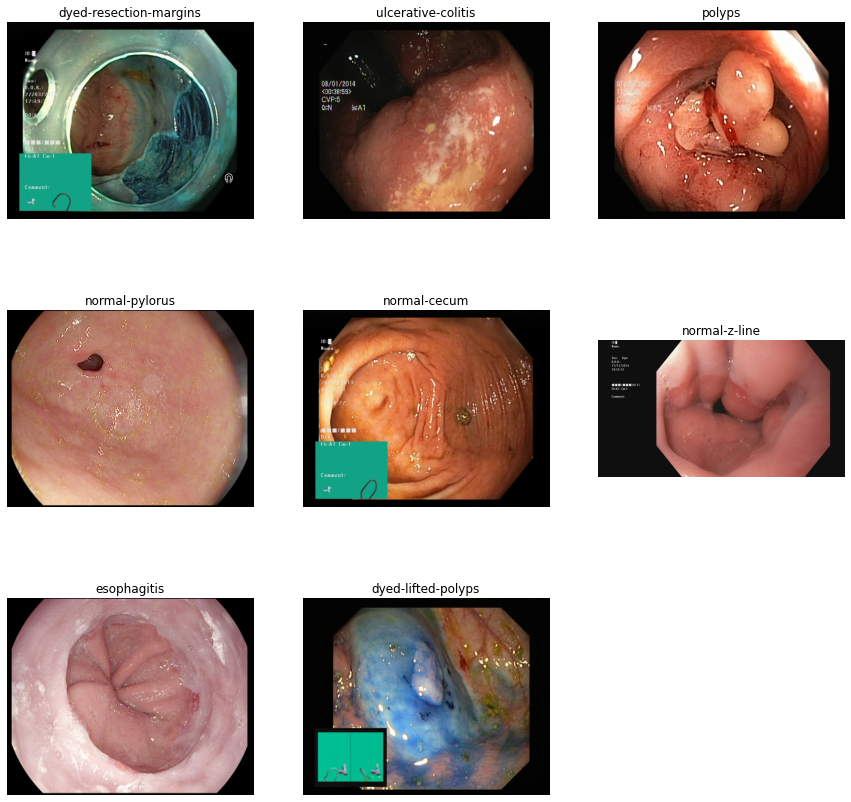

In [9]:
# Show one example for each category

plt.figure(figsize=(15, 15))
plot_num = 1
for cat_dir in glob.glob(datadir +"/*"):
  img_path = random.choice(os.listdir(cat_dir))
  img = cv2.imread(os.path.join(cat_dir,img_path))
  ax = plt.subplot(3, 3, plot_num)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  plt.title(cat_dir[27:])
  plt.axis("off")
  plot_num+=1



## Creating the model

#### Loading a pretrained CNN model

In [83]:
model = applications.DenseNet201(include_top = False, weights = "imagenet", input_shape = (img_size,img_size, 3))

In [84]:
model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

All the layers of the model are made trainable

In [85]:
for layer in model.layers:
    layer.trainable=True

#### Creating a data augmentation pipeline

In [25]:
# Custom data augmentation layer to randomly change brightness of the image. However, using random brightness worsens model performance

class RandomBrightness(tf.keras.layers.Layer):
    def __init__(self, brightness_delta, **kwargs):
        super(RandomBrightness, self).__init__(**kwargs)
        self.brightness_delta = brightness_delta

    def call(self, images, training=None):
        if not training:
            return images
        
        brightness = np.random.uniform(
            -self.brightness_delta, self.brightness_delta)
        
        images = tf.image.adjust_brightness(images, brightness)
        return images

In [86]:
data_augmentation = tf.keras.Sequential(
  [
    # RandomBrightness(0.3),
    layers.experimental.preprocessing.RandomContrast(0.3),
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_size, 
                                                              img_size,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

#### Compiling the final model

In [87]:
metrics = ["accuracy",
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives()
           ]

In [88]:
inputs = tf.keras.Input(shape=(img_size,img_size,3))
augmented = data_augmentation(inputs)
model_input = tf.keras.applications.densenet.preprocess_input(augmented)
output = model(model_input)
x = tf.keras.layers.GlobalAveragePooling2D()(output)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
predictions = tf.keras.layers.Dense(len(categories), activation="softmax")(x)

model_final = tf.keras.Model(inputs=inputs, outputs=predictions)

In [89]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9),metrics=metrics)

In [90]:
model_final.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_7 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0   

## Training

In [91]:
# Creating callbacks to be used during training

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [92]:
history=model_final.fit(train_ds.prefetch(tf.data.AUTOTUNE).cache(),
          epochs=30,
          verbose=1,
          validation_data=val_ds.prefetch(tf.data.AUTOTUNE).cache(),
          callbacks = [anne,checkpoint,early_stopping])

Epoch 1/30
200/200 [==============================] - 132s 532ms/step - loss: 1.5683 - accuracy: 0.3952 - precision_3: 0.6960 - recall_3: 0.1554 - auc_3: 0.7871 - true_positives_3: 752.6468 - true_negatives_3: 22381.3234 - false_positives_3: 241.5622 - false_negatives_3: 2479.1940 - val_loss: 0.3480 - val_accuracy: 0.8581 - val_precision_3: 0.8659 - val_recall_3: 0.8431 - val_auc_3: 0.9905 - val_true_positives_3: 1349.0000 - val_true_negatives_3: 10991.0000 - val_false_positives_3: 209.0000 - val_false_negatives_3: 251.0000

Epoch 00001: val_loss improved from inf to 0.34799, saving model to model.h5
Epoch 2/30
200/200 [==============================] - 65s 324ms/step - loss: 0.4245 - accuracy: 0.8387 - precision_3: 0.8594 - recall_3: 0.8081 - auc_3: 0.9863 - true_positives_3: 2639.0149 - true_negatives_3: 22213.5423 - false_positives_3: 409.3433 - false_negatives_3: 592.8259 - val_loss: 0.2564 - val_accuracy: 0.8956 - val_precision_3: 0.8999 - val_recall_3: 0.8938 - val_auc_3: 0.9940 

## Load saved model to continue training

If a saved model exists, it can be loaded and training can start from where it was left off

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
# Enter correct h5 file path
save_dir = "/content/gdrive/MyDrive/Models/KVASIR-DenseNet201-0.934.h5"

In [28]:
saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Creating callbacks to be used during training

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history=saved_model.fit(train_ds.prefetch(tf.data.AUTOTUNE).cache(),
          epochs=10,
          verbose=1,
          validation_data=val_ds.prefetch(tf.data.AUTOTUNE).cache(),
          callbacks = [anne,checkpoint,early_stopping])

## Visualizing training history

In [93]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_3', 'recall_3', 'auc_3', 'true_positives_3', 'true_negatives_3', 'false_positives_3', 'false_negatives_3', 'val_loss', 'val_accuracy', 'val_precision_3', 'val_recall_3', 'val_auc_3', 'val_true_positives_3', 'val_true_negatives_3', 'val_false_positives_3', 'val_false_negatives_3', 'lr'])

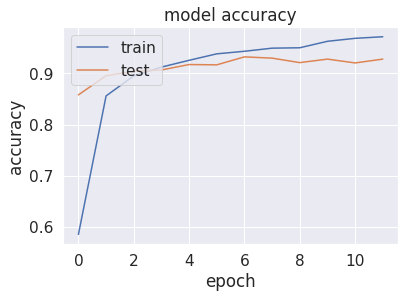

In [94]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

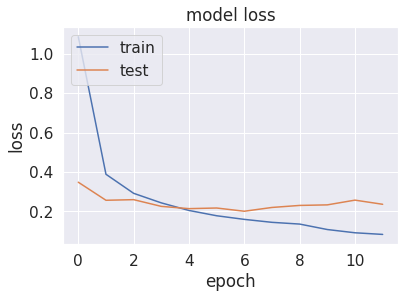

In [95]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating the final model

#### Load model

Load locally saved model

In [96]:
final_model_dir = "/content/model.h5"

Or load model saved in Google Drive

In [66]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [39]:
final_model_dir = "/content/gdrive/MyDrive/Models/KVASIR-DenseNet201-932.h5"

Load the model in final_model_dir into final_model

In [97]:
final_model = tf.keras.models.load_model(final_model_dir)

#### Evaluation

In [99]:
final_model.evaluate(val_ds)

50/50 [==============================] - 22s 390ms/step - loss: 0.2007 - accuracy: 0.9325 - precision_3: 0.9341 - recall_3: 0.9306 - auc_3: 0.9954 - true_positives_3: 1489.0000 - true_negatives_3: 11095.0000 - false_positives_3: 105.0000 - false_negatives_3: 111.0000


[0.20071078836917877,
 0.9325000047683716,
 0.9341279864311218,
 0.9306250214576721,
 0.9954118728637695,
 1489.0,
 11095.0,
 105.0,
 111.0]

The final model has an accuracy of **93.25%** along with precision of **93.41%** and recall of **93.06%**

#### Confusion matrix and classification report

Since tf.data.Dataset does not fetch images from disk in the same order, so we need to load the validation dataset into memory for consistency

In [100]:
x = []
y = []
for image,label in val_ds:
  x.append(image)
  y.append(label)

In [101]:
# Last image batch is removed due to its smaller size
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(50, 32, 224, 224, 3)
(50, 32, 8)


In [102]:
x = np.reshape(x,(x.shape[0]*x.shape[1],224,224,3))
y = np.reshape(y,(y.shape[0]*y.shape[1],y.shape[2]))

In [103]:
# Making predictions on the validation dataset
y_pred = final_model.predict(x)

In [104]:
predicted_categories = tf.argmax(y_pred, axis=-1)

In [105]:
true_categories = tf.argmax(y, axis=-1)

**The classification report**

In [106]:
print(classification_report(true_categories, predicted_categories))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       196
           1       0.94      0.94      0.94       209
           2       0.84      0.84      0.84       203
           3       0.98      1.00      0.99       212
           4       0.98      1.00      0.99       199
           5       0.82      0.81      0.82       185
           6       0.97      0.96      0.97       195
           7       0.98      0.97      0.97       201

    accuracy                           0.93      1600
   macro avg       0.93      0.93      0.93      1600
weighted avg       0.93      0.93      0.93      1600



**The confusion matrix**

In [107]:
conf_matrix = confusion_matrix(true_categories, predicted_categories)
print(conf_matrix)

[[182  12   0   1   0   0   1   0]
 [ 12 197   0   0   0   0   0   0]
 [  0   0 170   0   1  32   0   0]
 [  0   0   0 211   0   0   1   0]
 [  0   0   0   0 199   0   0   0]
 [  0   0  32   0   1 150   1   1]
 [  0   0   0   2   2   0 188   3]
 [  1   0   1   2   0   0   2 195]]


Plotting the confusion matrix using Seaborn



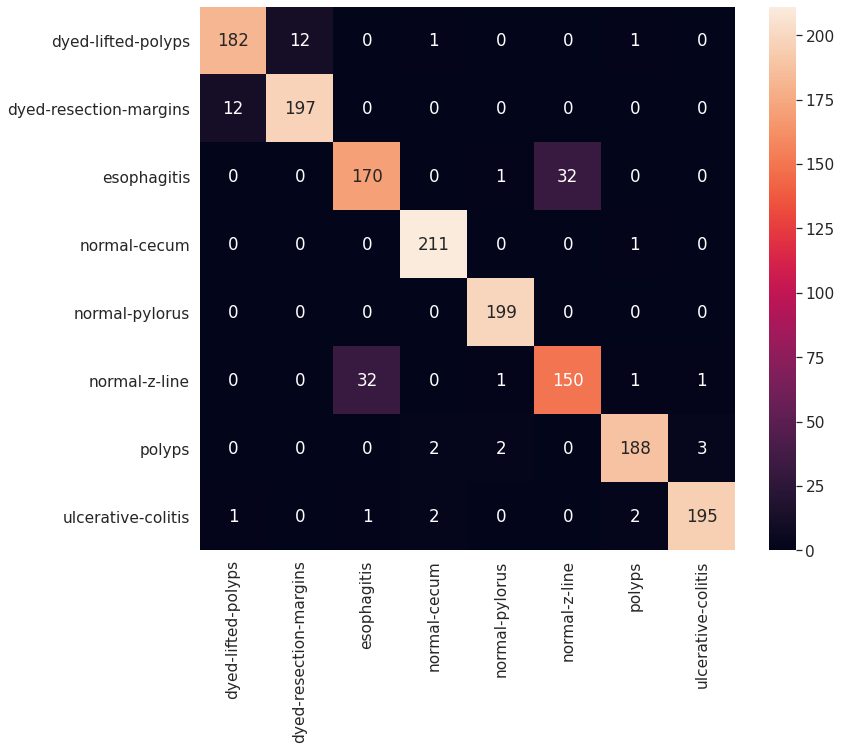

In [108]:
df_cm = pd.DataFrame(conf_matrix, val_ds.class_names, val_ds.class_names)
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='g') # font size

plt.show()

#### Save the model file to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [109]:
!mv "model.h5" "KVASIR-DenseNet201-932.h5"

In [110]:
!mv "KVASIR-DenseNet201-932.h5" "/content/gdrive/MyDrive/Models"

In [111]:
drive.flush_and_unmount()